In [1]:
import pandas as pd
file_path = "/home/newuser/Documents/Global_business_network_Data/Analysis daily results/202404data_process/global_all_sentence-t5-xxl_99th.csv"
global_business_network = pd.read_csv(file_path)
# 查看前几行数据
print(global_business_network.head())

   identifier1  identifier2  cos_sim  year
0            1        15799   0.8602  2000
1            1        20203   0.8608  2000
2            1        13687   0.8609  2000
3            1          962   0.8610  2000
4            1        48644   0.8611  2000


In [2]:
import pandas as pd
import os

# 输出文件夹路径
output_dir = "/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data"
# 按年份划分并保存
for year, group in global_business_network.groupby("year"):
    output_file = os.path.join(output_dir, f"global_business_network_{year}.csv")
    group.to_csv(output_file, index=False)
    print(f"保存年份 {year} 数据到 {output_file}")

保存年份 2000 数据到 /home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data/global_business_network_2000.csv
保存年份 2001 数据到 /home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data/global_business_network_2001.csv
保存年份 2002 数据到 /home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data/global_business_network_2002.csv
保存年份 2003 数据到 /home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data/global_business_network_2003.csv
保存年份 2004 数据到 /home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data/global_business_network_2004.csv
保存年份 2005 数据到 /home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis daily results/20250721/data/global_busine

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm

# 输入和输出路径
input_dir = "/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721/data"
output_file = "/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721/network_resilience_results.csv"

# 模拟攻击并计算 S(q)
def simulate_attack_resilience(G, attack_steps=np.arange(0, 0.55, 0.05), mode="degree"):
    N = G.number_of_nodes()
    results = []

    if mode == "degree":
        node_order = sorted(G.degree, key=lambda x: x[1], reverse=True)
        node_order = [n for n, _ in node_order]
    else:  # random
        node_order = list(G.nodes)
        np.random.shuffle(node_order)

    for q in attack_steps:
        num_remove = int(q * N)
        nodes_to_remove = node_order[:num_remove]

        G_attacked = G.copy()
        G_attacked.remove_nodes_from(nodes_to_remove)

        # 计算最大连通子图大小
        if G_attacked.number_of_nodes() == 0:
            S_q = 0
        else:
            largest_cc = max(nx.connected_components(G_attacked), key=len, default=set())
            S_q = len(largest_cc) / N
        results.append(S_q)
    return results

# 韧性指标 R = 平均 S(q)
def calculate_R(S_q):
    return np.mean(S_q)

# 遍历每一年
resilience_results = []

for year in tqdm(range(2000, 2022)):
    file_path = os.path.join(input_dir, f"global_business_network_{year}.csv")
    if not os.path.exists(file_path):
        print(f"❌ 文件不存在: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df_filtered = df[df["cos_sim"] > 0.8].copy()
    df_filtered["distance"] = 1 - df_filtered["cos_sim"]

    if df_filtered.empty:
        print(f"⚠️ {year} 年无有效边，跳过。")
        continue

    # 构建无向图
    G = nx.Graph()
    edges = list(zip(df_filtered["identifier1"], df_filtered["identifier2"], df_filtered["distance"]))
    G.add_weighted_edges_from(edges)

    # 攻击模拟
    S_q = simulate_attack_resilience(G, mode="degree")
    R = calculate_R(S_q)

    resilience_results.append({
        "year": year,
        "resilience_R": R,
        "attack_steps": S_q  # 可选，或者用 json.dumps(S_q) 保存详细曲线
    })

# 保存结果表
results_df = pd.DataFrame(resilience_results)
results_df.to_csv(output_file, index=False)
print(f"✅ 韧性分析完成，结果保存至：{output_file}")

100%|██████████| 22/22 [51:47<00:00, 141.24s/it]

✅ 韧性分析完成，结果保存至：/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721/network_resilience_results.csv


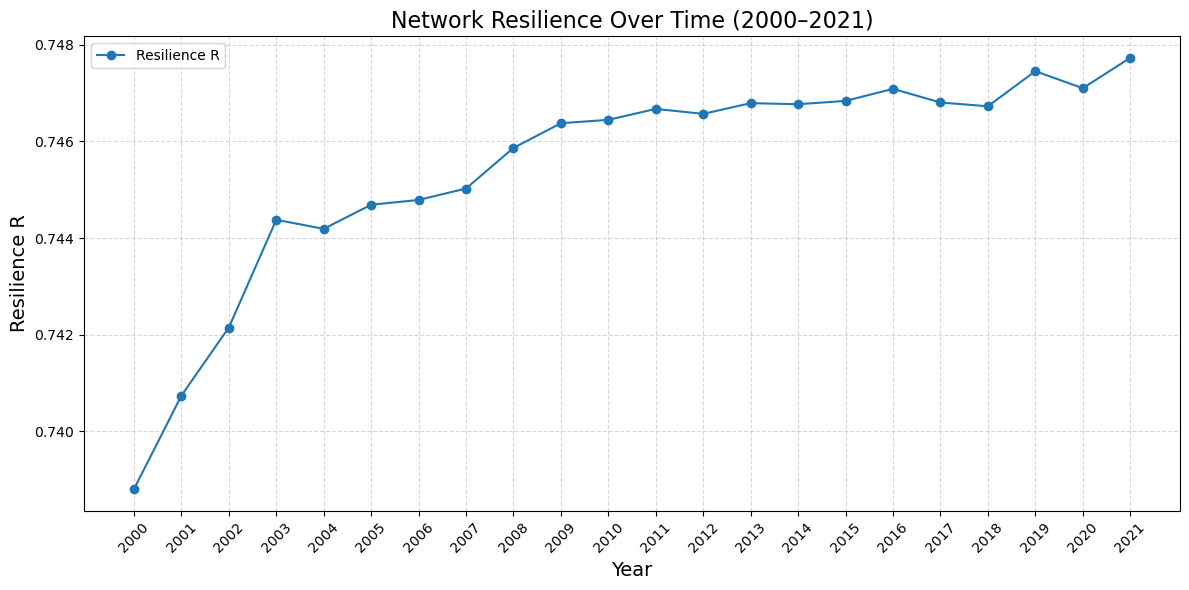

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置文件路径
file_path = "/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721/network_resilience_results.csv"

# 读取韧性结果数据
df = pd.read_csv(file_path)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['resilience_R'], marker='o', linestyle='-', color='tab:blue', label='Resilience R')

# 美化图形
plt.title('Network Resilience Over Time (2000–2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Resilience R', fontsize=14)
plt.xticks(df['year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 文件路径
input_file = "/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721/network_resilience_results.csv"
output_dir = "/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721"
output_file = os.path.join(output_dir, "network_resilience_over_time.png")

# 创建输出目录（如果不存在）
os.makedirs(output_dir, exist_ok=True)

# 读取数据
df = pd.read_csv(input_file)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['resilience_R'], marker='o', linestyle='-', color='tab:blue', label='Resilience R')

plt.title('Network Resilience Over Time (2000–2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Resilience R', fontsize=14)
plt.xticks(df['year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()

# 保存图像
plt.savefig(output_file, dpi=300)
plt.close()

print(f"✅ 图像已成功保存到：{output_file}")

✅ 图像已成功保存到：/home/newuser/Documents/Global_business_network_Data/Global_business_network_Data0718/Analysis_daily_results/20250721/network_resilience_over_time.png


# 对每一年的做随机节点攻击，计算每个q下最大连通子图的规模占原始节点数的比例S（q），并在n_trial上做实验。

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm

# 输入和输出路径
input_dir = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/data"
output_file = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R"

# # 随机攻击并计算 S(q)，做 n_trials 次取平均
# def simulate_attack_resilience_random(G, attack_steps=np.arange(0, 0.55, 0.05), n_trials=100, seed=42):
#     rng = np.random.default_rng(seed)
#     N = G.number_of_nodes()
#     S_q_sum = np.zeros(len(attack_steps), dtype=float)

#     nodes = list(G.nodes)

#     for _ in range(n_trials):
#         node_order = nodes.copy()
#         rng.shuffle(node_order)

#         trial_Sq = []
#         for idx, q in enumerate(attack_steps):
#             num_remove = int(q * N)
#             nodes_to_remove = node_order[:num_remove]

#             G_attacked = G.copy()
#             G_attacked.remove_nodes_from(nodes_to_remove)

#             if G_attacked.number_of_nodes() == 0:
#                 S_q = 0.0
#             else:
#                 largest_cc = max(nx.connected_components(G_attacked), key=len, default=set())
#                 S_q = len(largest_cc) / N
#             trial_Sq.append(S_q)

#         S_q_sum += np.array(trial_Sq)

#     return (S_q_sum / n_trials).tolist()
def simulate_attack_resilience_random(G, attack_steps=np.arange(0, 0.55, 0.05), n_trials=100, seed=42):
    rng = np.random.default_rng(seed)
    N = G.number_of_nodes()
    nodes = np.array(list(G.nodes()))
    S_q_sum = np.zeros(len(attack_steps), dtype=float)

    # 预先把每个 q 转成「要删除的节点数」
    remove_counts = (attack_steps * N).astype(int)

    for _ in range(n_trials):
        order_idx = rng.permutation(N)          # 随机节点顺序（索引）
        G_attacked = G.copy()                   # 本 trial 只拷贝一次
        last = 0
        trial_Sq = []

        for rc in remove_counts:
            # 增量删除：只删“新增加的这一段”
            if rc > last:
                batch = nodes[order_idx[last:rc]]
                G_attacked.remove_nodes_from(batch)
                last = rc

            # 计算最大连通子图占比
            if G_attacked.number_of_nodes() == 0:
                S_q = 0.0
            else:
                largest_cc = max(nx.connected_components(G_attacked), key=len, default=set())
                S_q = len(largest_cc) / N
            trial_Sq.append(S_q)

        S_q_sum += np.array(trial_Sq)

    return (S_q_sum / n_trials).tolist()
# 韧性指标 R = 平均 S(q)
def calculate_R(S_q):
    return float(np.mean(S_q))

# 遍历每一年
resilience_results = []
for year in tqdm(range(2000, 2022)):
    file_path = os.path.join(input_dir, f"global_business_network_{year}.csv")
    if not os.path.exists(file_path):
        print(f"❌ 文件不存在: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df_filtered = df[df["cos_sim"] > 0.8].copy()
    df_filtered["distance"] = 1 - df_filtered["cos_sim"]

    if df_filtered.empty:
        print(f"⚠️ {year} 年无有效边，跳过。")
        continue

    # 构建无向图（随机攻击不使用权重，仅基于拓扑）
    G = nx.Graph()
    G.add_edges_from(zip(df_filtered["identifier1"], df_filtered["identifier2"]))

    # 随机攻击（可调 n_trials 提升稳定性/速度）
    S_q = simulate_attack_resilience_random(G, n_trials=200, seed=2025)
    R = calculate_R(S_q)

    resilience_results.append({
        "year": year,
        "resilience_R": R,
        "attack_steps": S_q  # 如需存曲线可保留，也可改为 json.dumps(S_q)
    })

# 保存结果表
results_df = pd.DataFrame(resilience_results)
results_df.to_csv(output_file, index=False)
print(f"✅ 韧性分析完成（随机攻击），结果保存至：{output_file}")

100%|██████████| 22/22 [19:07:25<00:00, 3129.36s/it]  


IsADirectoryError: [Errno 21] Is a directory: '/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R'

In [ ]:
output_file = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R/network_resilience_random_results.csv"
results_df = pd.DataFrame(resilience_results)
results_df.to_csv(output_file, index=False)
print(f"✅ 韧性分析完成（随机攻击），结果保存至：{output_file}")

✅ 韧性分析完成（随机攻击），结果保存至：/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R/network_resilience_random_results.csv


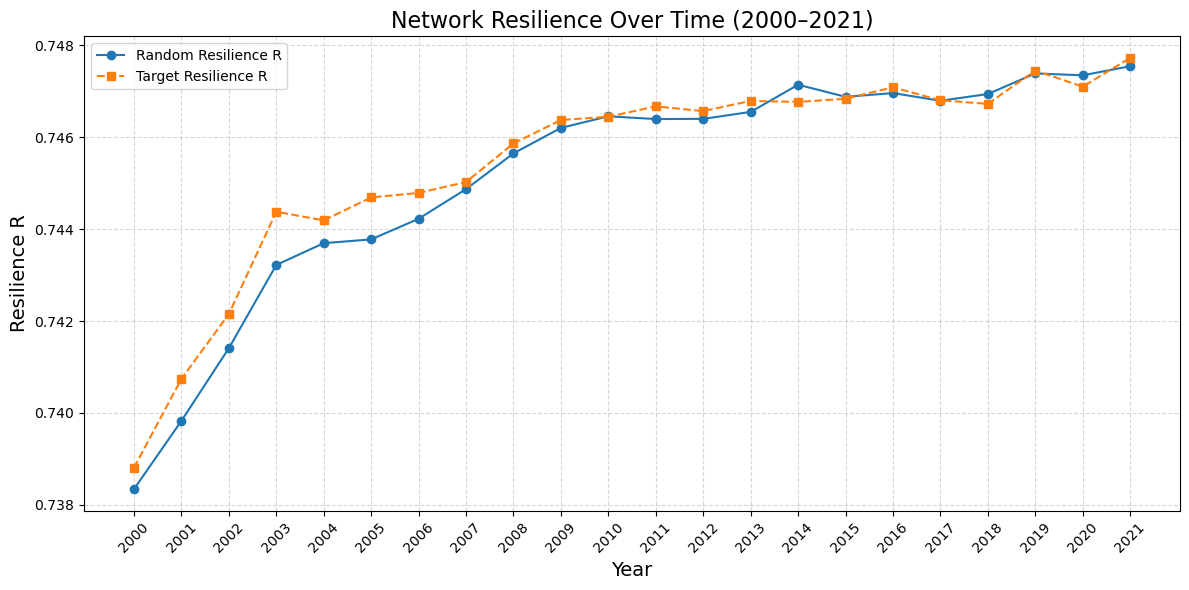

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1) 文件路径 ===
# 原始结果
file_path_target = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R/network_resilience_target_results.csv"
# target 结果
file_path_random = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R/network_resilience_random_results.csv"

# === 2) 读数据并规范列名 ===
def load_and_normalize(path, value_candidates):
    df = pd.read_csv(path)
    # 统一年份列名
    if 'year' not in df.columns:
        # 尝试常见大小写
        for c in ['Year', 'YEAR']:
            if c in df.columns:
                df = df.rename(columns={c: 'year'})
                break
    # 找到韧性值列
    val_col = None
    for c in value_candidates:
        if c in df.columns:
            val_col = c
            break
    if val_col is None:
        raise KeyError(f"在文件 {path} 中没有找到韧性列（候选名：{value_candidates}）")
    return df[['year', val_col]].rename(columns={val_col: 'value'})

df_random   = load_and_normalize(file_path_random,  ['resilience_R', 'random_resilience_R', 'R'])
df_target = load_and_normalize(file_path_target,['resilience_R', 'target_resilience_R', 'resilience_target_R', 'resilience'])

# === 3) 合并对齐（外连接，保留两边所有年份） ===
df_plot = (df_random.rename(columns={'value':'resilience_main'})
                 .merge(df_target.rename(columns={'value':'resilience_target'}),
                        on='year', how='outer')
                 .sort_values('year'))

# === 4) 绘图 ===
plt.figure(figsize=(12, 6))

# 原始结果
plt.plot(df_plot['year'], df_plot['resilience_main'],
         marker='o', linestyle='-', color='tab:blue', label='Random Resilience R')

# target 结果
plt.plot(df_plot['year'], df_plot['resilience_target'],
         marker='s', linestyle='--', color='tab:orange', label='Target Resilience R')

# 美化
plt.title('Network Resilience Over Time (2000–2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Resilience R', fontsize=14)
plt.xticks(df_plot['year'], rotation=45)  # 合并后的年份刻度
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

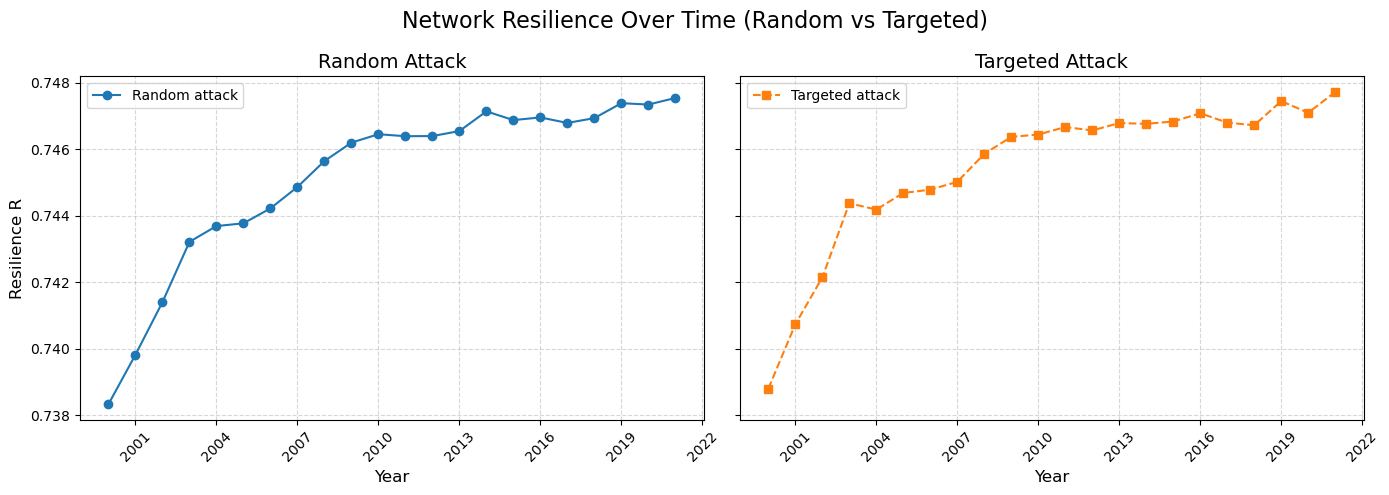

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# === 1) 文件路径 ===
file_path_target = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R/network_resilience_target_results.csv"
file_path_random = "/Users/jane/Documents/1.Global_business_network/Analysis daily results/20250721/20251021R/network_resilience_random_results.csv"

# === 2) 读数据并规范列名 ===
def load_and_normalize(path, value_candidates):
    df = pd.read_csv(path)
    if 'year' not in df.columns:
        for c in ['Year', 'YEAR']:
            if c in df.columns:
                df = df.rename(columns={c: 'year'})
                break
    val_col = next((c for c in value_candidates if c in df.columns), None)
    if val_col is None:
        raise KeyError(f"在 {path} 中找不到韧性列（候选：{value_candidates}）")
    return df[['year', val_col]].rename(columns={val_col: 'value'}).sort_values('year')

df_random = load_and_normalize(file_path_random, ['resilience_R', 'random_resilience_R', 'R'])
df_target = load_and_normalize(file_path_target, ['resilience_R', 'target_resilience_R', 'resilience_target_R', 'resilience'])

# === 3) 统一年份并合并，便于对齐坐标 ===
df_plot = (df_random.rename(columns={'value': 'resilience_random'})
                 .merge(df_target.rename(columns={'value': 'resilience_target'}),
                        on='year', how='outer')
                 .sort_values('year'))

# 计算统一 y 轴范围（给一点边距）
vals = np.r_[df_plot['resilience_random'].to_numpy(dtype=float),
             df_plot['resilience_target'].to_numpy(dtype=float)]
vals = vals[~np.isnan(vals)]
ymin, ymax = np.nanmin(vals), np.nanmax(vals)
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ymin, ymax = ymin - pad, ymax + pad

# === 4) 分别绘制：随机攻击 vs 目标攻击 ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# 随机攻击
m = df_plot['resilience_random'].notna()
axes[0].plot(df_plot.loc[m, 'year'], df_plot.loc[m, 'resilience_random'],
             marker='o', linestyle='-', color='tab:blue', label='Random attack')
axes[0].set_title('Random Attack', fontsize=14)
axes[0].set_ylabel('Resilience R', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# 目标攻击
m = df_plot['resilience_target'].notna()
axes[1].plot(df_plot.loc[m, 'year'], df_plot.loc[m, 'resilience_target'],
             marker='s', linestyle='--', color='tab:orange', label='Targeted attack')
axes[1].set_title('Targeted Attack', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# 统一坐标与刻度
for ax in axes:
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylim(ymin, ymax)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # 年份整数刻度
    ax.tick_params(axis='x', rotation=45)

fig.suptitle('Network Resilience Over Time (Random vs Targeted)', fontsize=16)
fig.tight_layout()
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Network resilience calculation (random vs targeted).
Outputs S(q) arrays and integral R for each attack type.
Requires: networkx, numpy, pandas, tqdm
pip install networkx numpy pandas tqdm
"""

import numpy as np
import networkx as nx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple, Dict, Any
import json
import math

def attack_steps_linspace(n_steps: int = 101) -> np.ndarray:
    """返回 q 从 0 到 1 的 n_steps 点（包含端点）"""
    return np.linspace(0.0, 1.0, n_steps)

def compute_R_by_trapz(S_q: np.ndarray, attack_steps: np.ndarray) -> float:
    """用梯形积分计算 R = ∫_0^1 S(q) dq"""
    return float(np.trapz(S_q, attack_steps))

# -------------------------
# 随机攻击（多 trial 并行 / 增量删除）
# -------------------------
def simulate_random_Sq(
    G: nx.Graph,
    attack_steps: np.ndarray,
    n_trials: int = 200,
    seed: int = 2025,
    n_jobs: int = 4
) -> np.ndarray:
    """
    返回 S_q 的均值数组（长度 = len(attack_steps)）
    实现要点：
      - 对每次 trial 生成随机删除序列（索引 permutation）
      - 增量删除节点（避免每次重建整个图）
      - 并行多个 trial（ThreadPoolExecutor）
    """
    N = G.number_of_nodes()
    nodes = np.array(list(G.nodes()))
    remove_counts = (attack_steps * N).astype(int)

    def one_trial(trial_seed: int) -> np.ndarray:
        rng = np.random.default_rng(trial_seed)
        order_idx = rng.permutation(N)
        # use a copy of adjacency structure: we will remove nodes from a working set
        alive = np.ones(N, dtype=bool)
        # map indices -> node ids
        trial_Sq = []
        last = 0
        # Precompute adjacency list for speed if needed? We'll use networkx subgraph checks incremental:
        # For simplicity use networkx on the induced subgraph of alive nodes at each check.
        # For performance on big graphs consider using union-find or incremental DS.
        for rc in remove_counts:
            if rc > last:
                # mark removed indices
                alive[order_idx[last:rc]] = False
                last = rc
            # build subgraph of alive nodes (can be expensive for big graphs)
            alive_nodes = nodes[alive]
            if alive_nodes.size == 0:
                S_q = 0.0
            else:
                subG = G.subgraph(alive_nodes)
                # largest connected component size (for undirected)
                try:
                    largest_cc_size = max((len(c) for c in nx.connected_components(subG)), default=0)
                except Exception:
                    # fallback: if graph tiny, treat as empty
                    largest_cc_size = 0
                S_q = largest_cc_size / N
            trial_Sq.append(S_q)
        return np.array(trial_Sq, dtype=float)

    # submit trials in parallel
    seeds = [seed + i for i in range(n_trials)]
    if n_jobs is None or n_jobs <= 1:
        results = [one_trial(s) for s in seeds]
    else:
        with ThreadPoolExecutor(max_workers=n_jobs) as ex:
            futures = [ex.submit(one_trial, s) for s in seeds]
            results = [f.result() for f in tqdm(futures, desc="random trials", total=len(futures))]
    mean_Sq = np.mean(np.vstack(results), axis=0)
    return mean_Sq

# -------------------------
# 靶向攻击（degree 或 betweenness 等）
# 提供 static 与 adaptive 两种策略
# -------------------------
def simulate_targeted_Sq(
    G: nx.Graph,
    attack_steps: np.ndarray,
    strategy: str = "degree",
    mode: str = "static",
    recompute_step: int = 1
) -> np.ndarray:
    """
    strategy: "degree" 或 "betweenness" 或 "pagerank"
    mode: "static"（只按初始度/指标排序）或 "adaptive"（每删除 recompute_step 批次后重算）
    recompute_step: adaptive 模式下每隔多少新增删除后重算一次（>=1）
    """
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    remove_counts = (attack_steps * N).astype(int)

    # helper to compute score dict
    def compute_scores(subG: nx.Graph) -> Dict[Any, float]:
        if strategy == "degree":
            return dict(subG.degree())
        if strategy == "betweenness":
            # note: betweenness expensive O(n*m)
            return nx.betweenness_centrality(subG, normalized=True)
        if strategy == "pagerank":
            return nx.pagerank(subG)
        raise ValueError("unsupported strategy")

    # initial scores on full G
    curr_sub_nodes = set(nodes)
    curr_score_map = compute_scores(G)
    # order nodes descending by score (highest first) -> nodes to remove earlier
    ordered = sorted(curr_score_map.items(), key=lambda x: (-x[1], x[0]))
    removal_order = [n for n, _ in ordered]

    if mode == "static":
        # use removal_order fixed
        removal_sequence = removal_order
    else:
        # adaptive: we will iteratively remove in batches and recompute scores
        removal_sequence = []
        G_work = G.copy()
        while G_work.number_of_nodes() > 0:
            scores = compute_scores(G_work)
            ordered = sorted(scores.items(), key=lambda x: (-x[1], x[0]))
            batch = [n for n, _ in ordered[:recompute_step]]
            # if batch empty break
            if not batch:
                break
            removal_sequence.extend(batch)
            G_work.remove_nodes_from(batch)
        # if sequence shorter than N, append remaining nodes arbitrarily
        if len(removal_sequence) < N:
            remaining = [n for n in nodes if n not in removal_sequence]
            removal_sequence.extend(remaining)

    # Now compute S(q) by incrementally removing according to removal_sequence
    alive = set(nodes)
    trial_Sq = []
    last = 0
    for rc in remove_counts:
        if rc > last:
            # remove nodes removal_sequence[last:rc]
            to_remove = removal_sequence[last:rc]
            for v in to_remove:
                alive.discard(v)
            last = rc
        if len(alive) == 0:
            S_q = 0.0
        else:
            subG = G.subgraph(alive)
            largest_cc_size = max((len(c) for c in nx.connected_components(subG)), default=0)
            S_q = largest_cc_size / N
        trial_Sq.append(S_q)
    return np.array(trial_Sq, dtype=float)

# -------------------------
# wrapper: compute both random & targeted R for a given graph
# -------------------------
def compute_resilience_for_graph(
    G: nx.Graph,
    n_steps: int = 101,
    random_trials: int = 200,
    random_seed: int = 2025,
    random_jobs: int = 4,
    target_strategy: str = "degree",
    target_mode: str = "static"
) -> Dict[str, Any]:
    attack_steps = attack_steps_linspace(n_steps)
    # random
    Sq_random = simulate_random_Sq(G, attack_steps, n_trials=random_trials, seed=random_seed, n_jobs=random_jobs)
    R_random = compute_R_by_trapz(Sq_random, attack_steps)
    # targeted
    Sq_target = simulate_targeted_Sq(G, attack_steps, strategy=target_strategy, mode=target_mode)
    R_target = compute_R_by_trapz(Sq_target, attack_steps)
    return {
        "attack_steps": attack_steps.tolist(),
        "Sq_random": Sq_random.tolist(),
        "R_random": float(R_random),
        "Sq_target": Sq_target.tolist(),
        "R_target": float(R_target)
    }

# -------------------------
# Example usage for one year's edge list CSV
# -------------------------
if __name__ == "__main__":
    import pandas as pd
    # 修改为你的路径与字段名
    edge_csv = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/data/global_business_network_2000.csv"  # CSV must have columns: identifier1, identifier2 (or source, target)
    df_edges = pd.read_csv(edge_csv)
    # 例如你的 edges 表列名为 identifier1, identifier2
    if "identifier1" in df_edges.columns and "identifier2" in df_edges.columns:
        edges = list(zip(df_edges["identifier1"], df_edges["identifier2"]))
    elif "source" in df_edges.columns and "target" in df_edges.columns:
        edges = list(zip(df_edges["source"], df_edges["target"]))
    else:
        raise RuntimeError("请确认边表的列名 (identifier1/identifier2 或 source/target)")

    G = nx.Graph()
    G.add_edges_from(edges)
    # 可选：过滤孤立节点，或保留都可
    print("N nodes:", G.number_of_nodes(), "N edges:", G.number_of_edges())

    res = compute_resilience_for_graph(
        G,
        n_steps=101,
        random_trials=200,
        random_seed=2025,
        random_jobs=4,
        target_strategy="degree",   # or "betweenness", "pagerank"
        target_mode="static"        # or "adaptive"
    )

    # 保存到文件
    with open("resilience_example_2000.json", "w") as f:
        json.dump(res, f, indent=2)
    print("R_random =", res["R_random"])
    print("R_target =", res["R_target"])
    
# N nodes: 15426 N edges: 1283671
# random trials: 100%|██████████| 200/200 [3:29:35<00:00, 62.88s/it]   
# /var/folders/np/ry82r7v95y33d2df6jpjnr4c0000gn/T/ipykernel_86497/126356493.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
#   return float(np.trapz(S_q, attack_steps))
# R_random = 0.48513241605082336
# R_target = 0.4494992220925709

N nodes: 15426 N edges: 1283671


random trials: 100%|██████████| 200/200 [3:29:35<00:00, 62.88s/it]   
/var/folders/np/ry82r7v95y33d2df6jpjnr4c0000gn/T/ipykernel_86497/126356493.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(S_q, attack_steps))


R_random = 0.48513241605082336
R_target = 0.4494992220925709


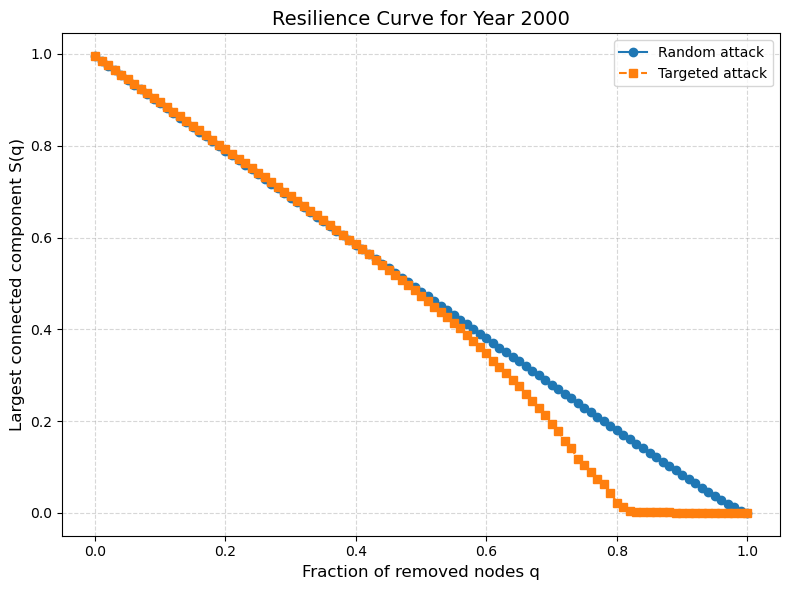

In [4]:
import json
import matplotlib.pyplot as plt

# ====== 1. 读取文件 ======
json_path = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/resilience_example_2000.json"

with open(json_path, "r") as f:
    data = json.load(f)

attack_steps = data["attack_steps"]
Sq_random = data.get("Sq_random", None)
Sq_target = data.get("Sq_target", None)

year = data.get("year", "Unknown")

# ====== 2. 绘图 ======
plt.figure(figsize=(8, 6))

if Sq_random:
    plt.plot(attack_steps, Sq_random, marker="o", color="tab:blue",
             label="Random attack")

if Sq_target:
    plt.plot(attack_steps, Sq_target, marker="s", linestyle="--", color="tab:orange",
             label="Targeted attack")

plt.xlabel("Fraction of removed nodes q", fontsize=12)
plt.ylabel("Largest connected component S(q)", fontsize=12)
plt.title(f"Resilience Curve for Year 2000", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig(f"resilience_attack_curve_{year}.png", dpi=300)
plt.show()

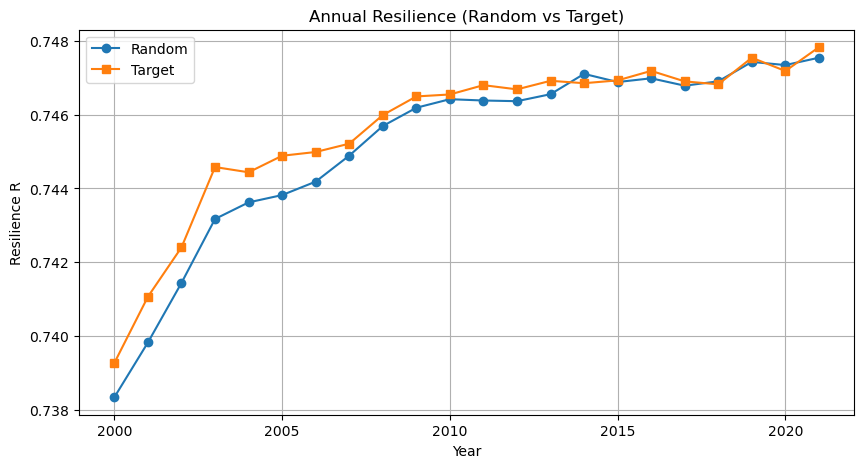

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/resilience_summary_parallel.csv")

plt.figure(figsize=(10,5))
plt.plot(df["year"], df["R_random"], marker='o', label="Random")
plt.plot(df["year"], df["R_target"], marker='s', label="Target")
plt.xlabel("Year")
plt.ylabel("Resilience R")
plt.title("Annual Resilience (Random vs Target)")
plt.legend()
plt.grid(True)
plt.show()

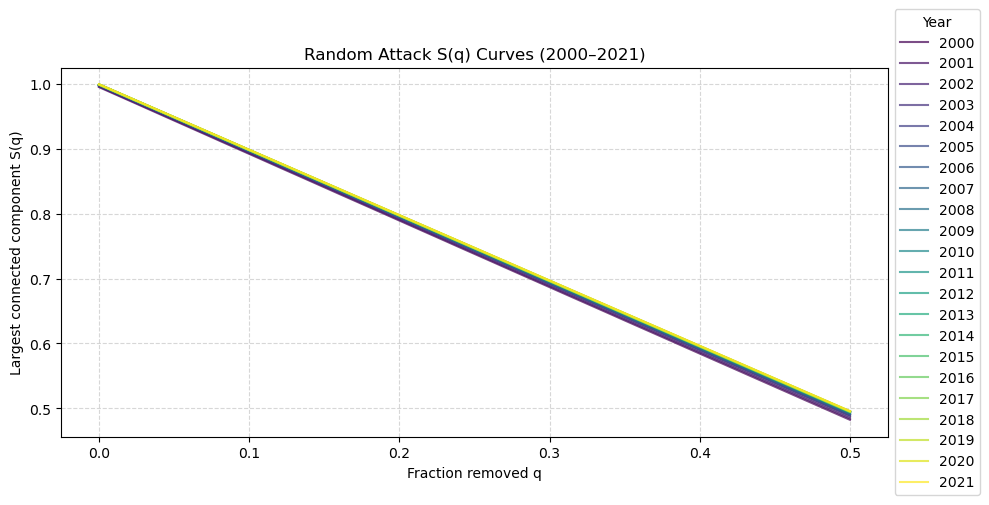

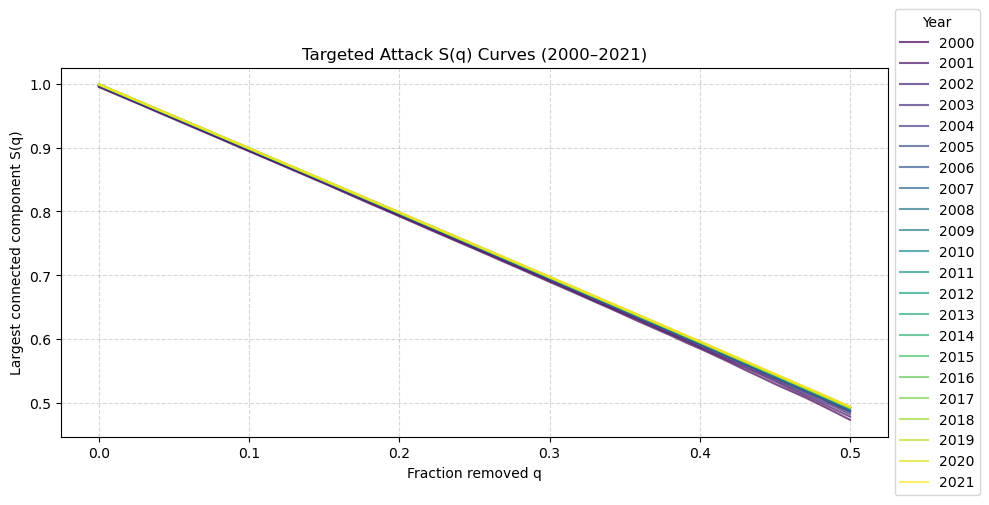

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# === 1. 设置 JSON 目录 ===
CURVE_DIR = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/Sq_curves"

# === 2. 读取所有 JSON 文件 ===
records = []
for fname in os.listdir(CURVE_DIR):
    if fname.endswith(".json"):
        year = int(fname.replace(".json",""))
        path = os.path.join(CURVE_DIR, fname)
        with open(path, "r") as f:
            data = json.load(f)
            records.append((year, data))

# 按年份排序
records = sorted(records, key=lambda x: x[0])


# === 3. 提取 attack_steps（所有年份应相同） ===
attack_steps = np.array(records[0][1]["attack_steps"])

# === 4. 画 Random Attack 曲线 ===
plt.figure(figsize=(10,5))
colors = cm.viridis(np.linspace(0,1,len(records)))

for (color, (year, data)) in zip(colors, records):
    Sq = np.array(data["Sq_random"])
    plt.plot(attack_steps, Sq, color=color, alpha=0.7, label=str(year))

plt.title("Random Attack S(q) Curves (2000–2021)")
plt.xlabel("Fraction removed q")
plt.ylabel("Largest connected component S(q)")
plt.grid(True, ls="--", alpha=0.5)

# 图例放在右侧外部
plt.legend(loc="center left", bbox_to_anchor=(1,0.5), title="Year")
plt.tight_layout()
plt.show()


# === 5. 画 Targeted Attack 曲线 ===
plt.figure(figsize=(10,5))
for (color, (year, data)) in zip(colors, records):
    Sq = np.array(data["Sq_target"])
    plt.plot(attack_steps, Sq, color=color, alpha=0.7, label=str(year))

plt.title("Targeted Attack S(q) Curves (2000–2021)")
plt.xlabel("Fraction removed q")
plt.ylabel("Largest connected component S(q)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend(loc="center left", bbox_to_anchor=(1,0.5), title="Year")
plt.tight_layout()
plt.show()

R与alpha

合并表已保存: /Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/merged_resilience_alpha.csv
相关性结果已保存: /Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/correlation_results.txt
散点图已保存: /Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/resilience_vs_alpha_scatter.png


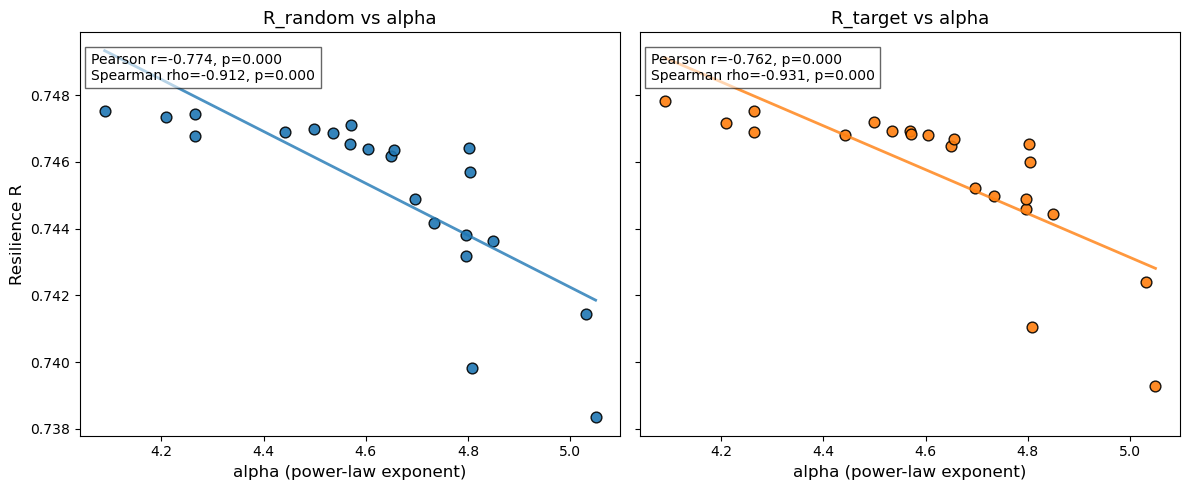

In [5]:
# -*- coding: utf-8 -*-
"""
将韧性结果与 power-law alpha 结果合并并做相关性分析与可视化
输出：
 - merged_resilience_alpha.csv
 - correlation_results.txt
 - 两张散点图 png（R_random vs alpha, R_target vs alpha）
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ========== 用户文件路径（根据需要修改）==========
path_resilience = r"/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/resilience_summary_parallel.csv"
path_alpha      = r"/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250402/powerlaw_alpha_results.csv"

out_dir = os.path.dirname(path_resilience)
os.makedirs(out_dir, exist_ok=True)

# ========== 读取 ==========
df_res = pd.read_csv(path_resilience)
df_alpha = pd.read_csv(path_alpha)

# ========== 清洗 alpha：按 year 聚合（若有重复行取均值） ==========
# 确保 year 是整数
df_alpha['year'] = pd.to_numeric(df_alpha['year'], errors='coerce').astype('Int64')
df_alpha = df_alpha.dropna(subset=['year'])

# 如果 alpha 列名不是 'alpha'，尝试几个常见名字
alpha_col_candidates = ['alpha', 'Alpha', 'power_law_alpha']
alpha_col = None
for c in alpha_col_candidates:
    if c in df_alpha.columns:
        alpha_col = c
        break
if alpha_col is None:
    # 若没有找到，尝试使用第二列作为 alpha（用户文件中第二列应为 alpha）
    alpha_col = df_alpha.columns[1]

# 聚合重复年份：取均值（也可选择 median）
df_alpha_clean = df_alpha.groupby('year', as_index=False)[alpha_col].mean().rename(columns={alpha_col: 'alpha'})

# ========== 清洗 resilience：确保 year 列存在，并把列名规范化 ==========
df_res['year'] = pd.to_numeric(df_res['year'], errors='coerce').astype('Int64')
# 规范韧性列名
if 'R_random' not in df_res.columns:
    # 尝试查找类似列
    for cand in ['R_random', 'resilience_random', 'random_resilience', 'R_rand']:
        if cand in df_res.columns:
            df_res = df_res.rename(columns={cand: 'R_random'})
            break
if 'R_target' not in df_res.columns:
    for cand in ['R_target', 'resilience_target', 'target_resilience', 'R_targ']:
        if cand in df_res.columns:
            df_res = df_res.rename(columns={cand: 'R_target'})
            break

# 保留需要的列（若缺则报错提醒）
need_cols = ['year', 'R_random', 'R_target']
for c in need_cols:
    if c not in df_res.columns:
        raise KeyError(f"resilience 文件缺少必要列: {c}")

df_res_clean = df_res[need_cols].dropna(subset=['year']).copy()

# ========== 合并（inner join 只保留两表共有年份） ==========
df = pd.merge(df_res_clean, df_alpha_clean, on='year', how='inner').sort_values('year').reset_index(drop=True)

# 保存合并表（便于后续检查）
merged_path = os.path.join(out_dir, "merged_resilience_alpha.csv")
df.to_csv(merged_path, index=False)
print(f"合并表已保存: {merged_path}")

# ========== 计算相关性（Pearson + Spearman） ==========
def corr_stats(x, y):
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x2, y2 = x[mask], y[mask]
    if len(x2) < 3:
        return {'n': len(x2), 'pearson_r': np.nan, 'pearson_p': np.nan,
                'spearman_rho': np.nan, 'spearman_p': np.nan}
    r, p = stats.pearsonr(x2, y2)
    rho, p_s = stats.spearmanr(x2, y2)
    return {'n': len(x2), 'pearson_r': r, 'pearson_p': p,
            'spearman_rho': rho, 'spearman_p': p_s}

res_random = corr_stats(df['alpha'], df['R_random'])
res_target = corr_stats(df['alpha'], df['R_target'])

# 把结果写文件
txt_out = os.path.join(out_dir, "correlation_results.txt")
with open(txt_out, 'w') as f:
    f.write("Correlation between alpha and resilience\n\n")
    f.write("Merged years: {}\n\n".format(df['year'].tolist()))
    f.write("R_random vs alpha:\n")
    for k,v in res_random.items():
        f.write(f"  {k}: {v}\n")
    f.write("\nR_target vs alpha:\n")
    for k,v in res_target.items():
        f.write(f"  {k}: {v}\n")
print(f"相关性结果已保存: {txt_out}")

# ========== 绘图：两张并列散点图（并标注 pearson r&p） ==========
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# 通用绘图函数
def plot_scatter(ax, x, y, xlabel, ylabel, color, label, annotate_text):
    ax.scatter(x, y, color=color, s=60, edgecolor='k', alpha=0.9)
    # 拟合直线
    if len(x) >= 2:
        k, b = np.polyfit(x, y, 1)
        xs = np.linspace(min(x), max(x), 200)
        ax.plot(xs, k*xs + b, color=color, linewidth=2, alpha=0.8)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(label, fontsize=13)
    ax.text(0.02, 0.95, annotate_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

# left: R_random
annot_rand = f"Pearson r={res_random['pearson_r']:.3f}, p={res_random['pearson_p']:.3f}\nSpearman rho={res_random['spearman_rho']:.3f}, p={res_random['spearman_p']:.3f}"
plot_scatter(axes[0], df['alpha'], df['R_random'], "alpha (power-law exponent)", "Resilience R", "C0", "R_random vs alpha", annot_rand)

# right: R_target
annot_targ = f"Pearson r={res_target['pearson_r']:.3f}, p={res_target['pearson_p']:.3f}\nSpearman rho={res_target['spearman_rho']:.3f}, p={res_target['spearman_p']:.3f}"
plot_scatter(axes[1], df['alpha'], df['R_target'], "alpha (power-law exponent)", "", "C1", "R_target vs alpha", annot_targ)

plt.tight_layout()
png_out = os.path.join(out_dir, "resilience_vs_alpha_scatter.png")
plt.savefig(png_out, dpi=300)
print(f"散点图已保存: {png_out}")
plt.show()

   year  R_random  R_target status  avg_degree  clustering_coef   density
0  2000  0.738347  0.739276     ok  332.859069         0.460302  0.010790
1  2001  0.739830  0.741069     ok  380.040130         0.447756  0.010832
2  2002  0.741442  0.742404     ok  415.825335         0.438126  0.010707
3  2003  0.743173  0.744579     ok  444.610254         0.434185  0.010622
4  2004  0.743622  0.744437     ok  466.938705         0.433882  0.010546


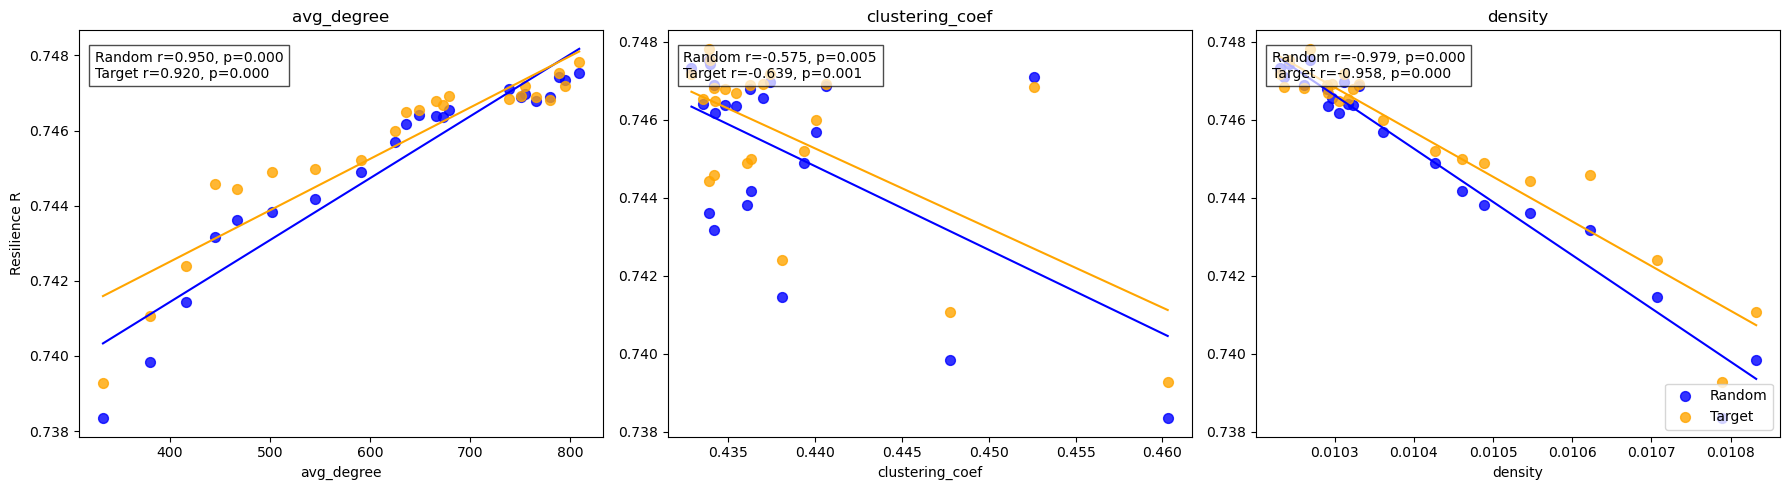

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# =======================
# 1. 读取数据
# =======================
path_res = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/resilience_summary_parallel.csv"
path_stats = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250402/full_year_network_stats.csv"

df_R = pd.read_csv(path_res)
df_stats = pd.read_csv(path_stats)

# 只保留所需字段
df_stats = df_stats[['year', 'avg_degree', 'clustering_coef', 'density']]

# 合并
df = df_R.merge(df_stats, on='year', how='inner')

print(df.head())

def compute_corr(df, x, y):
    px, py = pearsonr(df[x], df[y])
    sx, sy = spearmanr(df[x], df[y])
    return {
        "pearson_r": px, "pearson_p": py,
        "spearman_r": sx, "spearman_p": sy
    }
    
metrics = ["avg_degree", "clustering_coef", "density"]

corr_results = {}

for m in metrics:
    corr_results[m] = {
        "random": compute_corr(df, m, "R_random"),
        "target": compute_corr(df, m, "R_target")
    }

corr_results

plt.style.use("default")   # 最安全，不会报错

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    x = df[metric]
    y_r = df["R_random"]
    y_t = df["R_target"]

    # 画点
    ax.scatter(x, y_r, color="blue", label="Random", s=50, alpha=0.8)
    ax.scatter(x, y_t, color="orange", label="Target", s=50, alpha=0.8)

    # 回归线
    k_r, b_r = np.polyfit(x, y_r, 1)
    k_t, b_t = np.polyfit(x, y_t, 1)
    xs = np.linspace(x.min(), x.max(), 200)

    ax.plot(xs, k_r*xs + b_r, color="blue")
    ax.plot(xs, k_t*xs + b_t, color="orange")

    # 注释
    Rr = corr_results[metric]["random"]
    Rt = corr_results[metric]["target"]

    ax.text(
        0.03, 0.95,
        f"Random r={Rr['pearson_r']:.3f}, p={Rr['pearson_p']:.3f}\n"
        f"Target r={Rt['pearson_r']:.3f}, p={Rt['pearson_p']:.3f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7)
    )

    ax.set_title(metric)
    ax.set_xlabel(metric)
    if i == 0:
        ax.set_ylabel("Resilience R")

axes[2].legend(loc="lower right")
plt.tight_layout()
plt.show()

    


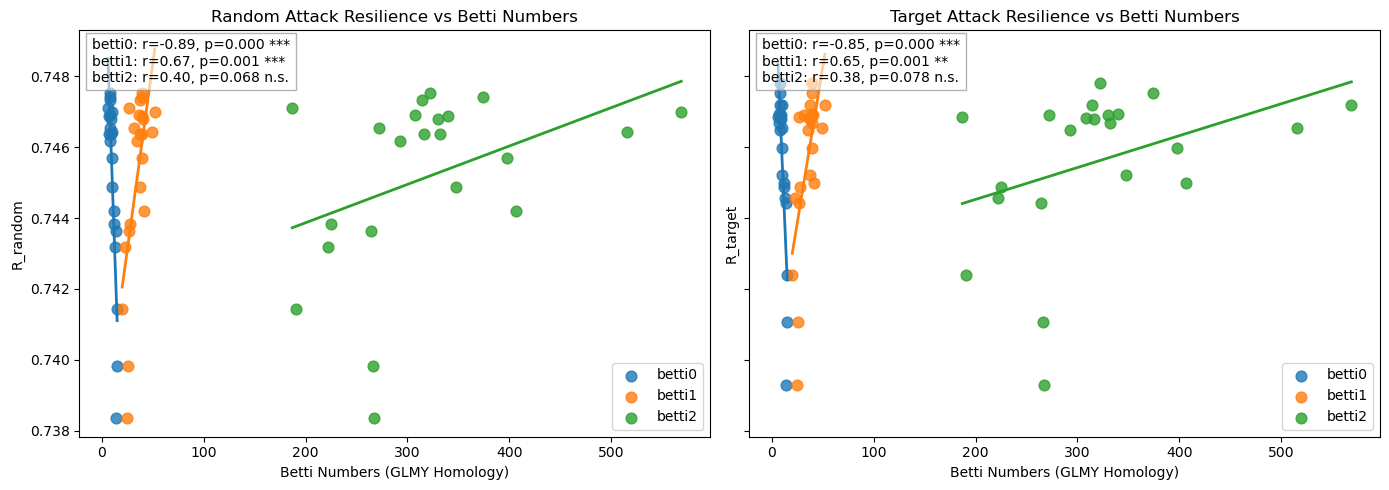

✅ 图已生成：GLMY_vs_resilience_with_significance.png


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# ================================
# 1) 读取韧性结果 (R_random / R_target)
# ================================
path_R = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/resilience_summary_parallel.csv"
df_R = pd.read_csv(path_R)
df_R = df_R[['year', 'R_random', 'R_target']]

# ================================
# 2) 读取 GLMY Betti 结果
# ================================
path_glmy = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250717My_GLMY2/Output/summary_glmy_dims.csv"
df_glmy = pd.read_csv(path_glmy)

df_glmy = df_glmy.rename(columns={
    "dim0": "betti0",
    "dim1": "betti1",
    "dim2": "betti2"
})

betti_cols = ["betti0", "betti1", "betti2"]

# ================================
# 3) 合并
# ================================
df = df_R.merge(df_glmy[['year'] + betti_cols], on='year', how='inner')

# ================================
# 4) 显著性符号函数
# ================================
def p_sig(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

# ================================
# 5) 绘图函数（可复用）
# ================================
def plot_with_reg(ax, df, R_col, title):
    colors = {
        "betti0": "#1f77b4",
        "betti1": "#ff7f0e",
        "betti2": "#2ca02c",
    }

    text_lines = []  # 存储标注内容

    for b in betti_cols:
        x = df[b].values
        y = df[R_col].values

        # 计算相关系数
        r, p = pearsonr(x, y)

        # 拟合直线
        k, bb = np.polyfit(x, y, 1)
        xs = np.linspace(min(x), max(x), 200)

        # 绘图
        ax.scatter(x, y, color=colors[b], s=60, alpha=0.8, label=b)
        ax.plot(xs, k*xs + bb, color=colors[b], linewidth=2)

        # 文字行
        text_lines.append(f"{b}: r={r:.2f}, p={p:.3f} {p_sig(p)}")

    # 将文字写入图左上角
    ax.text(
        0.02, 0.98,
        "\n".join(text_lines),
        transform=ax.transAxes,
        fontsize=10,
        va="top",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="gray")
    )

    ax.set_title(title)
    ax.set_xlabel("Betti Numbers (GLMY Homology)")
    ax.set_ylabel(R_col)
    ax.legend()


# ================================
# 6) 生成双图
# ================================
plt.style.use("default")
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_with_reg(axes[0], df, "R_random", "Random Attack Resilience vs Betti Numbers")
plot_with_reg(axes[1], df, "R_target", "Target Attack Resilience vs Betti Numbers")

plt.tight_layout()
plt.savefig("GLMY_vs_resilience_with_significance.png", dpi=300)
plt.show()

print("✅ 图已生成：GLMY_vs_resilience_with_significance.png")

In [25]:
def persistence_landscape_stats(intervals, n_grid=500):
    """
    计算 persistence landscape 的 L1 和 L2 范数。
    自动处理所有 death=-1 的情况。
    """
    if len(intervals) == 0:
        return 0.0, 0.0

    births = np.array([b for b, _ in intervals], float)
    deaths = np.array([d for _, d in intervals], float)

    # finite death
    finite = deaths[deaths != -1]

    # 如果全部 death = -1，则给它们一个有限 death 上界
    if len(finite) == 0:
        t_min = births.min()
        t_max = births.max() * 1.1
    else:
        t_min = births.min()
        t_max = finite.max() * 1.1

    grid = np.linspace(t_min, t_max, n_grid)

    landscapes = []

    for b, d in intervals:
        if d == -1:
            d = t_max   # 使用有限上界替代 ∞
        f = np.maximum(0, np.minimum(grid - b, d - grid))  # 正确 landscape 公式
        landscapes.append(f)

    L = np.max(np.vstack(landscapes), axis=0)

    L1 = np.trapz(L, grid)
    L2 = np.sqrt(np.trapz(L**2, grid))

    return float(L1), float(L2)

In [26]:
import re
import numpy as np
import pandas as pd
import pathlib

def parse_glmy_output(path):
    txt = open(path, encoding='utf-8').read()
    m = re.search(r"Homology:\s*(\{[\s\S]*?\})\s*Representative:", txt)
    if not m:
        raise RuntimeError(f"❌ 未找到 Homology 字典: {path}")

    hom_raw = m.group(1)
    hom_dict = eval(hom_raw)

    homology = {}
    for dim, items in hom_dict.items():
        dim = int(dim)
        homology[dim] = [(float(b), float(d)) for b, d in items]
    return homology


def get_persistence_list(intervals):
    if len(intervals)==0:
        return np.array([])

    finite = [d for _,d in intervals if d != -1]
    INF = max(finite)*1.1 if finite else 1.0

    pers=[]
    for b,d in intervals:
        pers.append((INF if d==-1 else d)-b)
    return np.array(pers)


def persistent_entropy(pers):
    if len(pers)==0:
        return 0
    L = pers.sum()
    p = pers / L
    p = p[p>0]
    return -np.sum(p*np.log(p))


def total_persistence(pers): return pers.sum()
def l1_norm(pers): return np.abs(pers).sum()
def l2_norm(pers): return np.sqrt((pers**2).sum())

def extract_topo_features_from_output(glmy_file, year):
    hom=parse_glmy_output(glmy_file)
    rec={"year":year}

    for dim, intervals in hom.items():
        pers=get_persistence_list(intervals)

        rec[f"dim{dim}_count"]=len(intervals)
        rec[f"dim{dim}_mean_pers"]=pers.mean() if len(pers)>0 else 0
        rec[f"dim{dim}_max_pers"]=pers.max() if len(pers)>0 else 0
        rec[f"dim{dim}_total_pers"]=pers.sum()
        rec[f"dim{dim}_entropy"]=persistent_entropy(pers)

        L1,L2=persistence_landscape_stats(intervals)
        rec[f"dim{dim}_land_l1"]=L1
        rec[f"dim{dim}_land_l2"]=L2

    return rec


# ===== 批量处理 =====
base_dir="/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250717My_GLMY2/Output"

records=[]
for year in range(2000,2022):
    file=f"{base_dir}/output_{year}.txt"
    rec=extract_topo_features_from_output(file, year)
    records.append(rec)

df=pd.DataFrame(records)
df.to_csv("glmy_topo_features_2000_2021.csv", index=False)

print("✅ 完成！glmy_topo_features_2000_2021.csv 已生成")

/var/folders/np/ry82r7v95y33d2df6jpjnr4c0000gn/T/ipykernel_97412/381652973.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  L1 = np.trapz(L, grid)
/var/folders/np/ry82r7v95y33d2df6jpjnr4c0000gn/T/ipykernel_97412/381652973.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  L2 = np.sqrt(np.trapz(L**2, grid))


✅ 完成！glmy_topo_features_2000_2021.csv 已生成


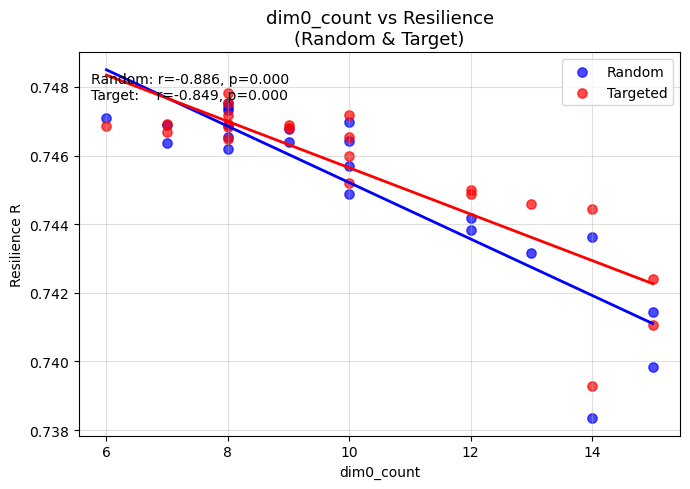

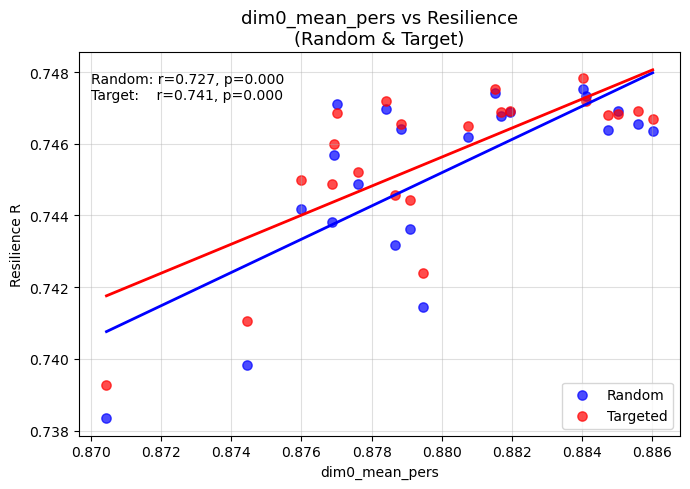

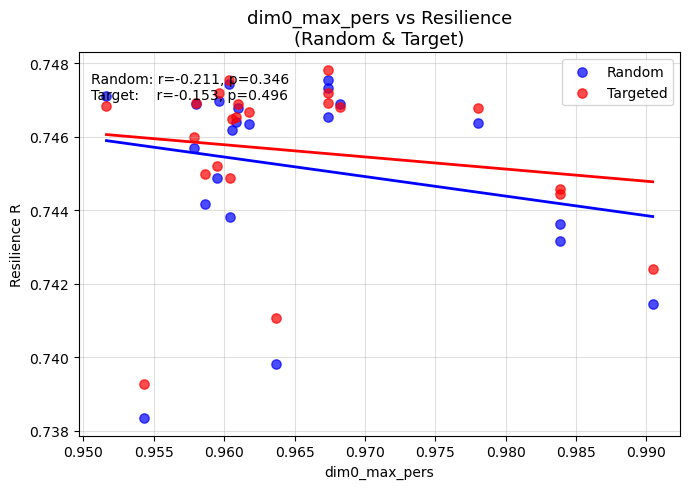

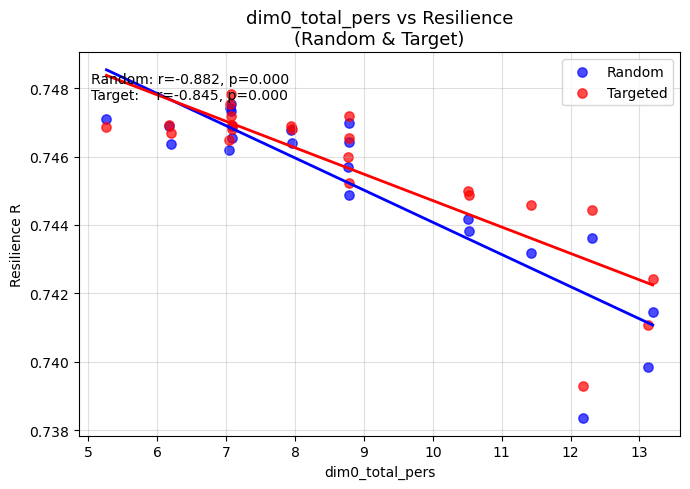

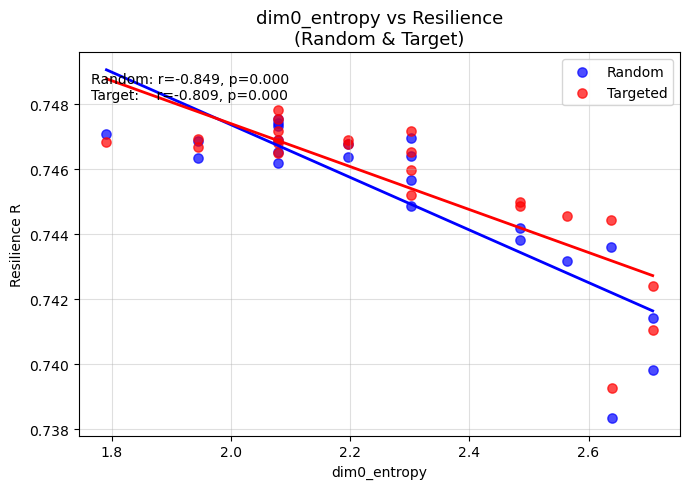

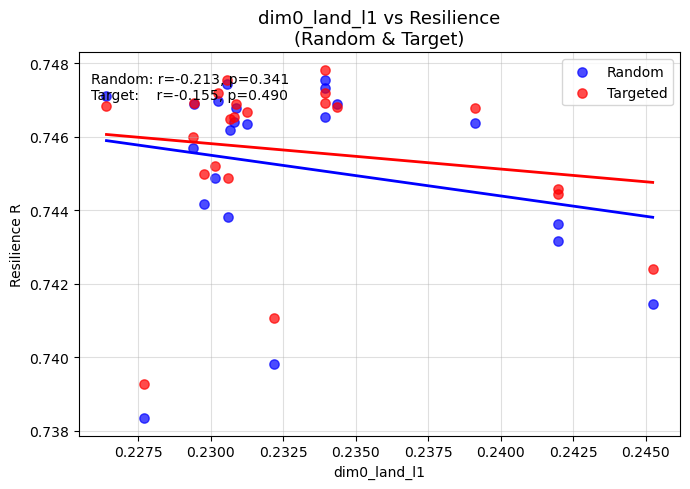

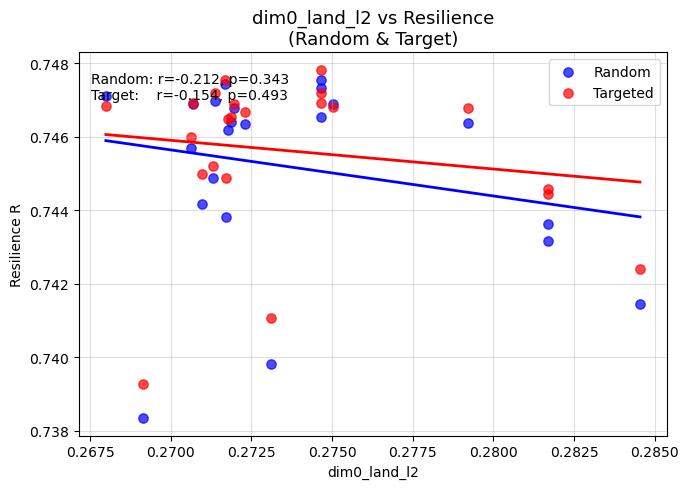

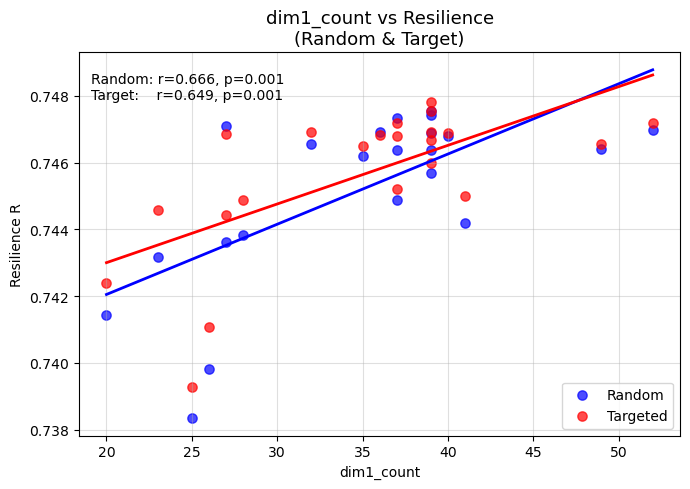

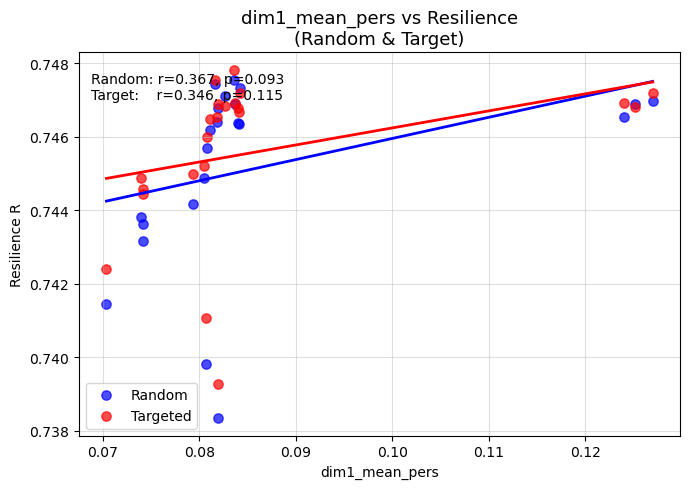

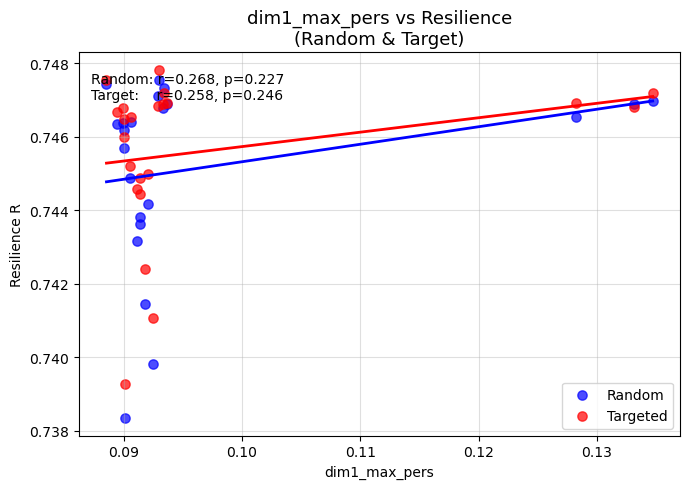

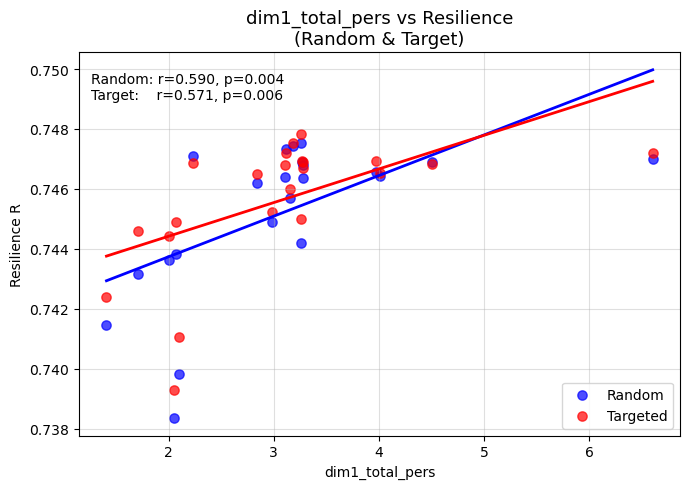

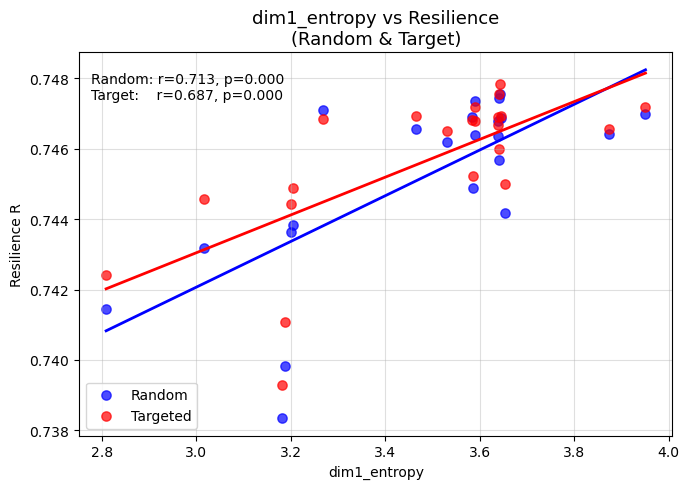

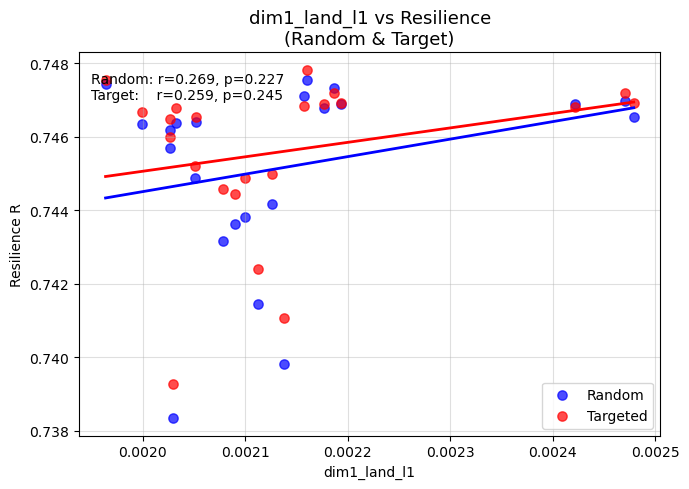

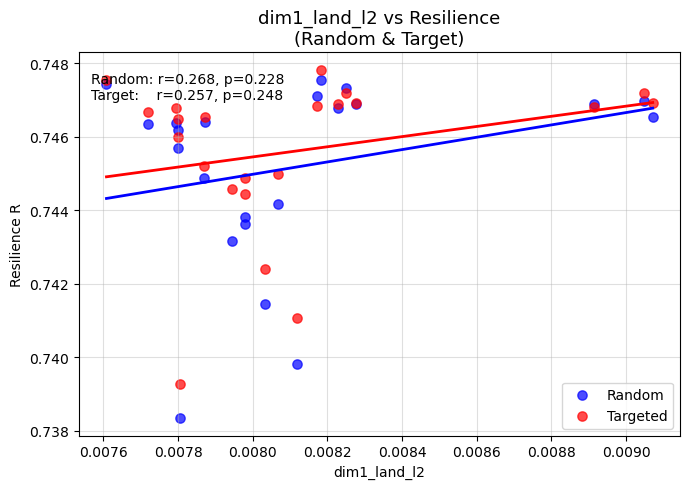

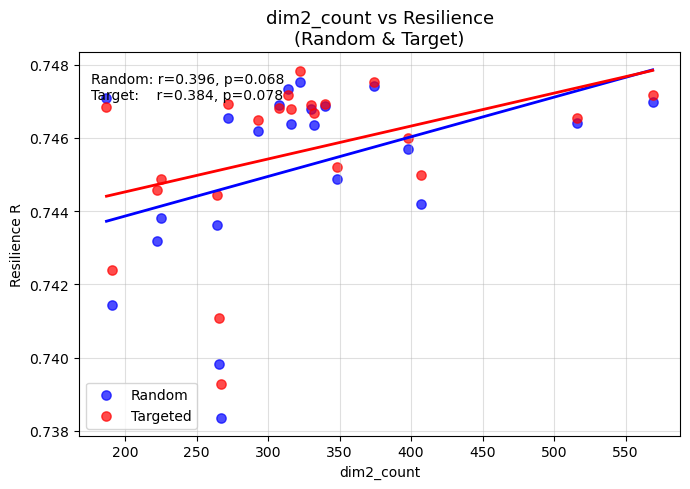

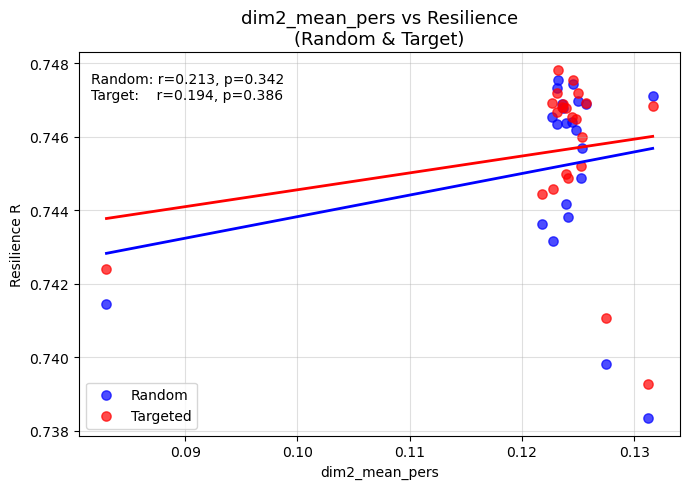

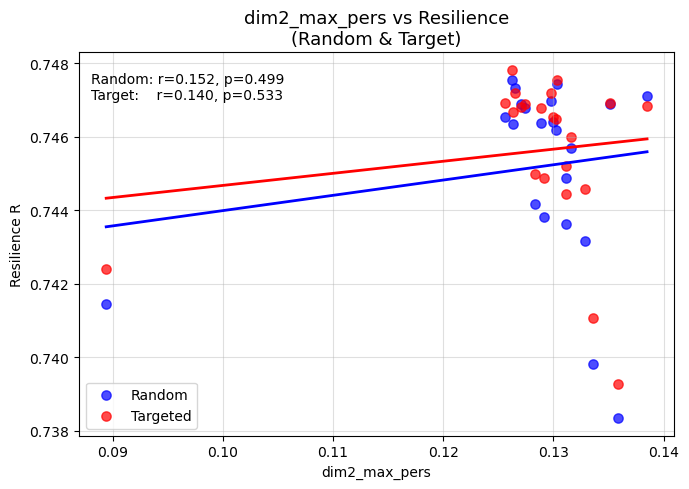

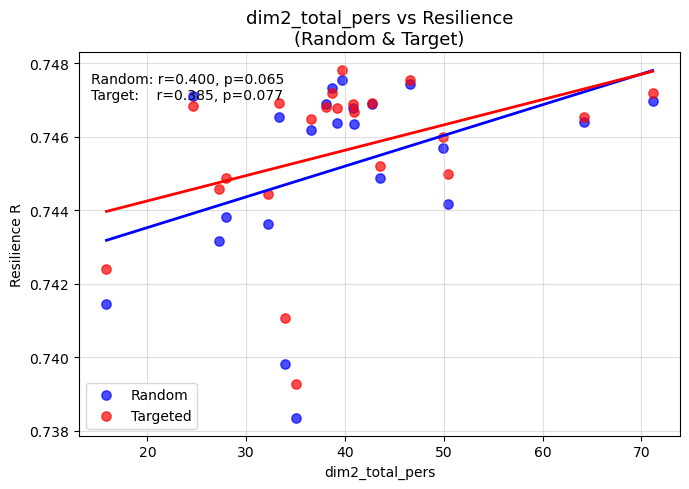

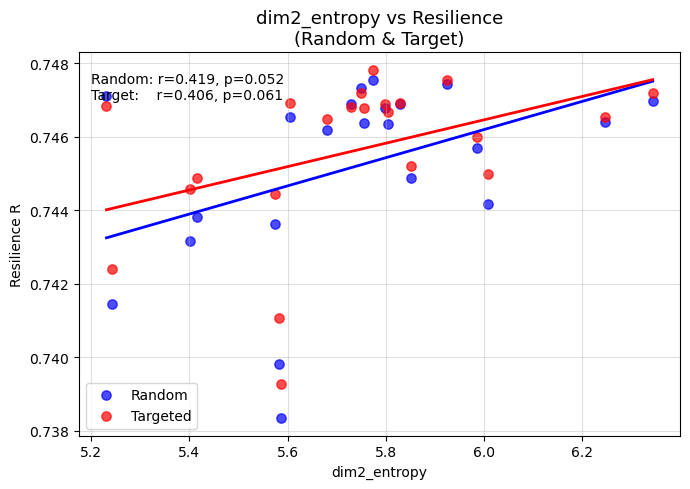

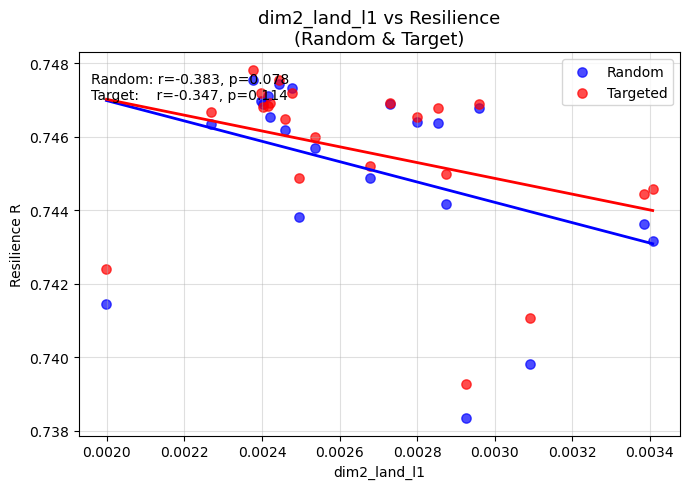

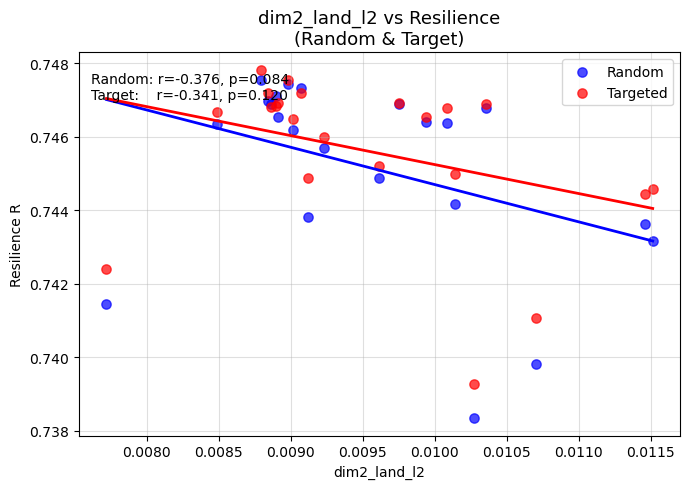

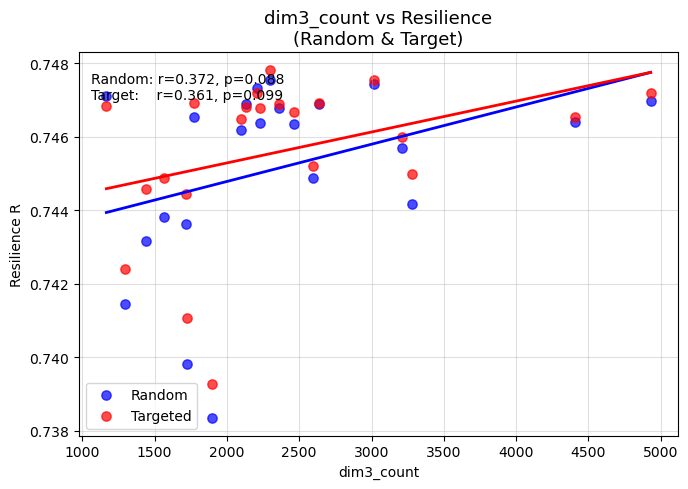

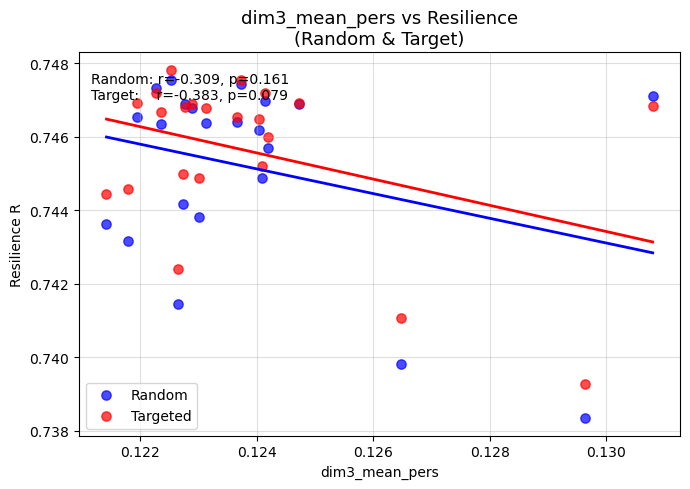

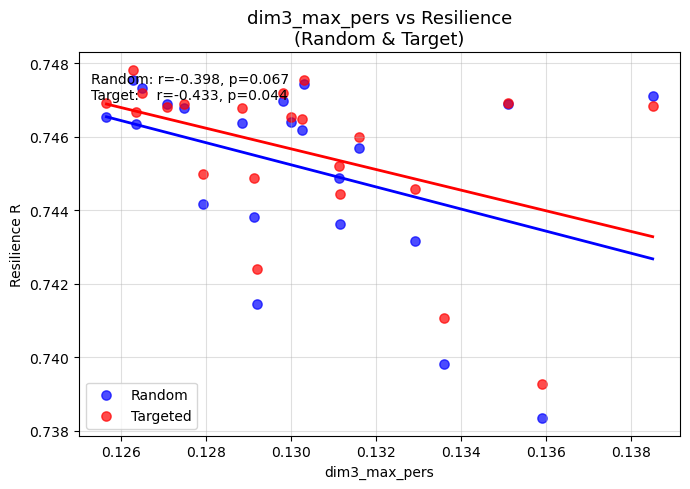

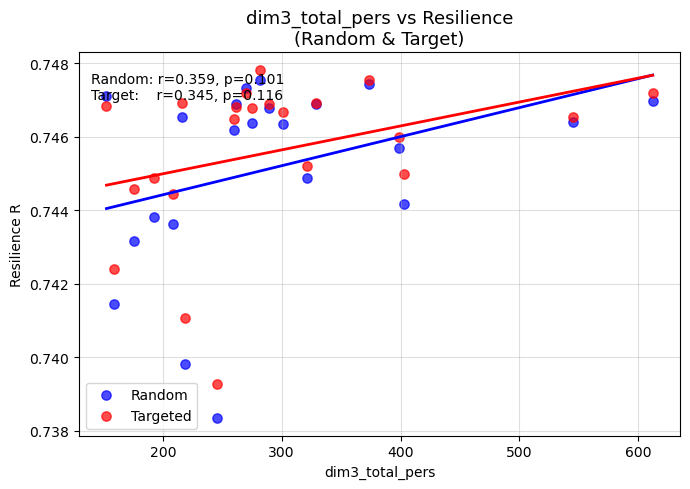

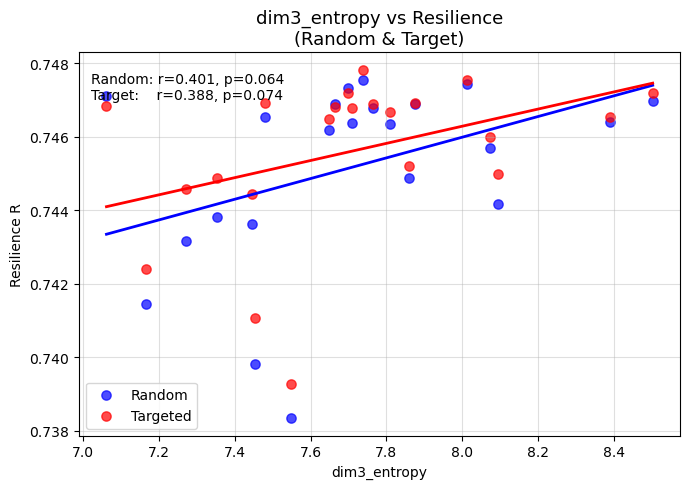

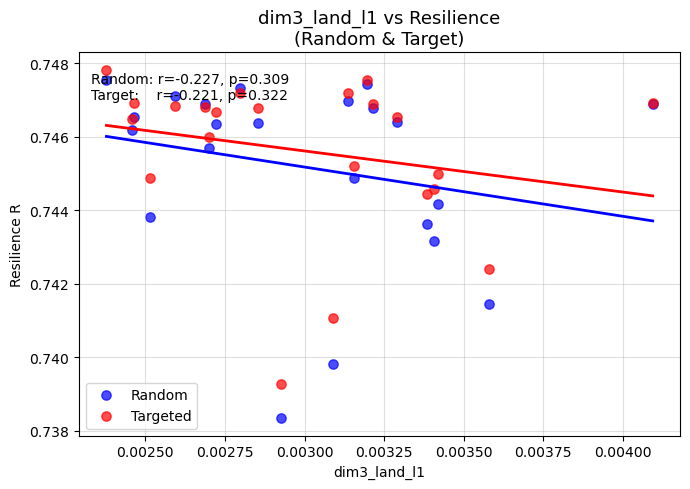

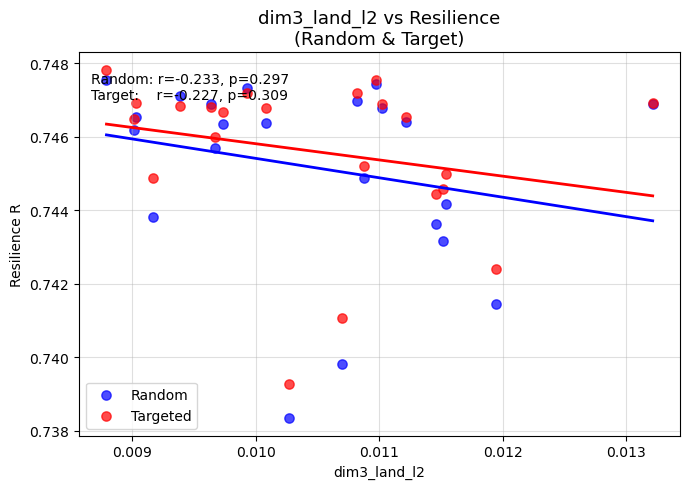

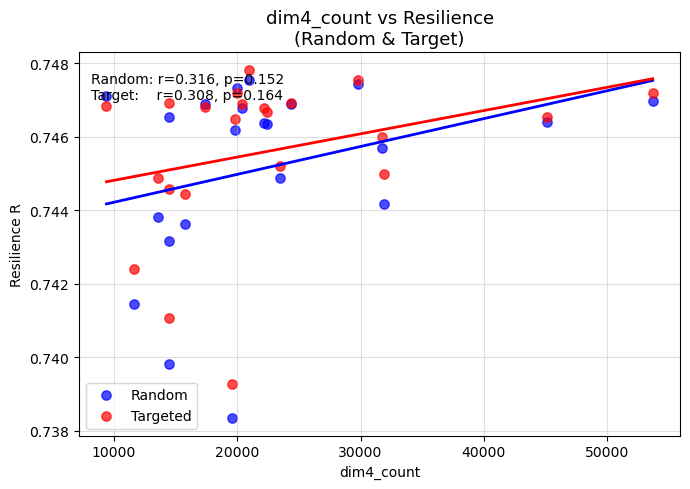

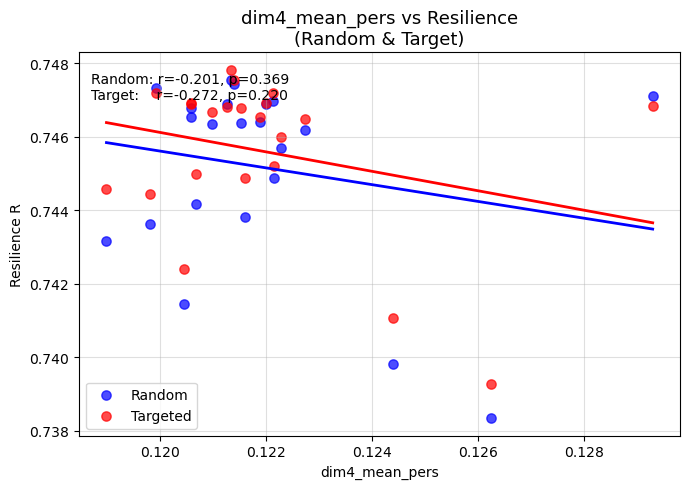

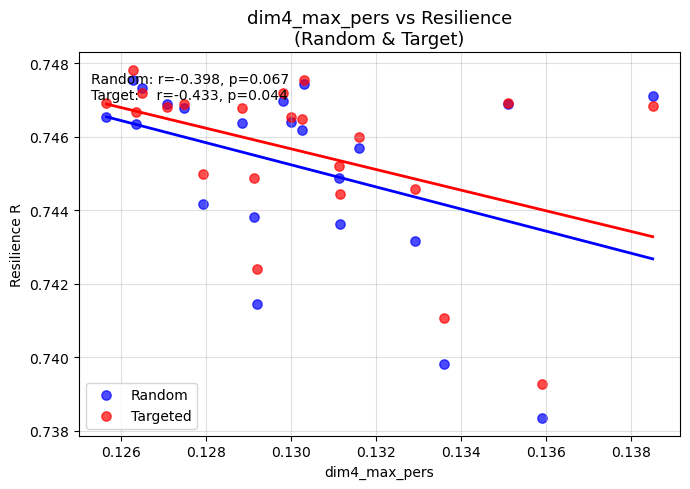

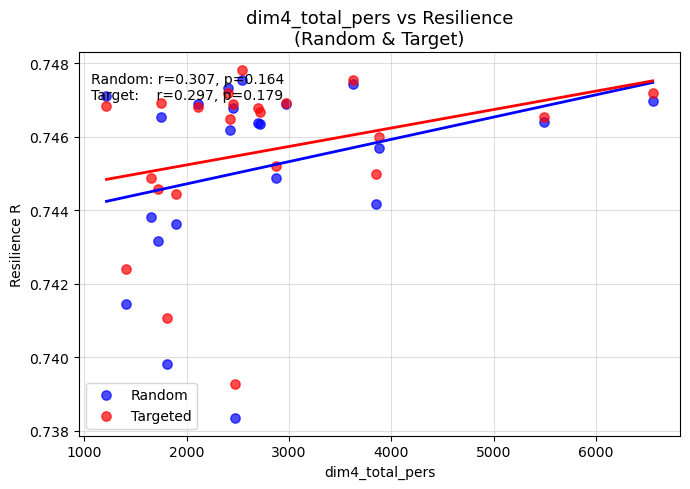

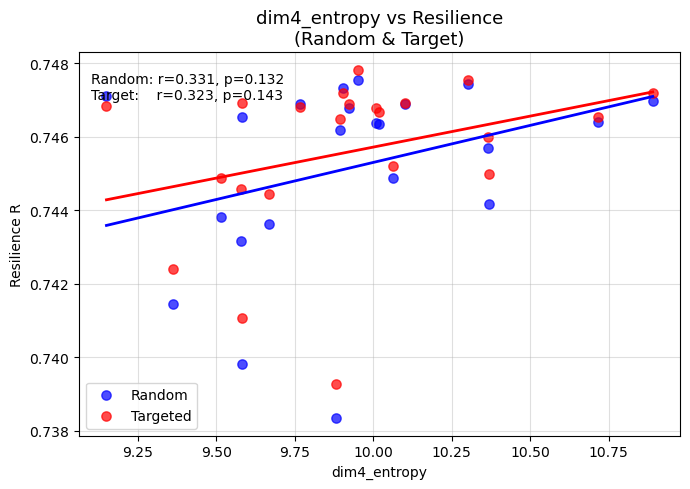

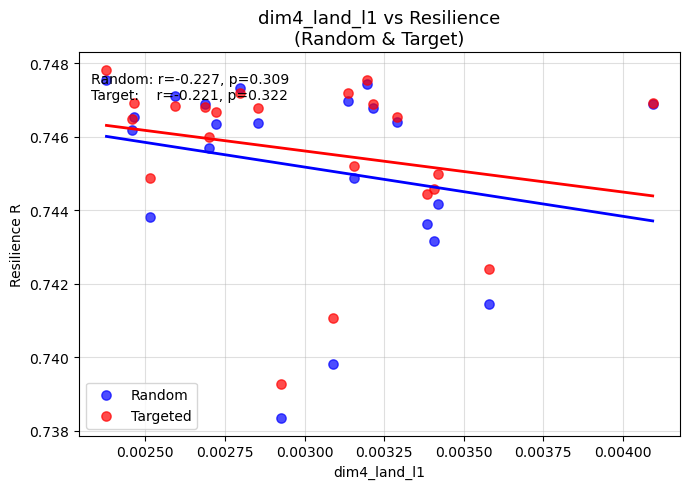

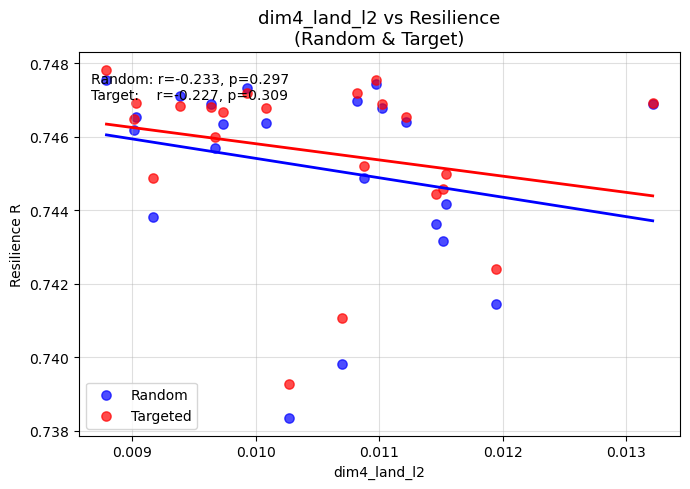

✅ 所有拓扑特征的比较图已生成（随机 vs 靶点）。


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# ---------- 文件路径 ----------
path_topo = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/glmy_topo_features_2000_2021.csv"
path_R    = "/Users/jane/Documents/1.Global_business_network/Analysis_daily_results/20250721R/parallel_out/resilience_summary_parallel.csv"

df_topo = pd.read_csv(path_topo)
df_R    = pd.read_csv(path_R)

# ---------- 合并 ----------
df = df_topo.merge(df_R[["year", "R_random", "R_target"]], on="year", how="inner")

# ---------- 有效拓扑特征 ----------
feature_cols = [c for c in df.columns 
                if c not in ["year", "R_random", "R_target", "status"]]

# ---------- 全局绘图函数（随机攻击 vs 靶向攻击，绘制在一张图） ----------
def plot_random_target(df, feature):
    fig, ax = plt.subplots(figsize=(7, 5))

    x = df[feature].values
    yr = df["R_random"].values
    yt = df["R_target"].values

    # ---- 散点 ----
    ax.scatter(x, yr, color="blue", alpha=0.7, label="Random", s=45)
    ax.scatter(x, yt, color="red",  alpha=0.7, label="Targeted", s=45)

    # ---- 拟合线 ----
    # Random
    m_r, b_r = np.polyfit(x, yr, 1)
    xfit = np.linspace(x.min(), x.max(), 200)
    ax.plot(xfit, m_r*xfit + b_r, color="blue", linewidth=2)

    # Target
    m_t, b_t = np.polyfit(x, yt, 1)
    ax.plot(xfit, m_t*xfit + b_t, color="red", linewidth=2)

    # ---- 相关性 ----
    r_r, p_r = pearsonr(x, yr)
    r_t, p_t = pearsonr(x, yt)

    ax.text(
        0.02, 0.95,
        f"Random: r={r_r:.3f}, p={p_r:.3f}\nTarget:    r={r_t:.3f}, p={p_t:.3f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top"
    )

    # ---- 标题与标签 ----
    ax.set_title(f"{feature} vs Resilience\n(Random & Target)", fontsize=13)
    ax.set_xlabel(feature)
    ax.set_ylabel("Resilience R")
    ax.legend()
    ax.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.savefig(f"scatter_random_target_{feature}.png", dpi=300)
    plt.show()


# ---------- 自动对所有拓扑特征绘图 ----------
for feat in feature_cols:
    plot_random_target(df, feat)

print("✅ 所有拓扑特征的比较图已生成（随机 vs 靶点）。")